# 2D Poisson Problem

In [7]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax

In [ ]:
print(jax.devices())
print(jax.default_backend())

[CudaDevice(id=0)]
gpu


: 

## Step 1: Create FEMSystem Object with Mesh and Element

In [2]:
# Create the FEMSystem Object
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
L = 5.0
mesh = mesh.scaled(2 * L).translated((-L, -L))
element = fem.ElementTriP1()
intorder = 3  

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

W1204 02:52:11.854157  223199 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 02:52:11.860793  222510 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Step 2: Define Optimization Objective

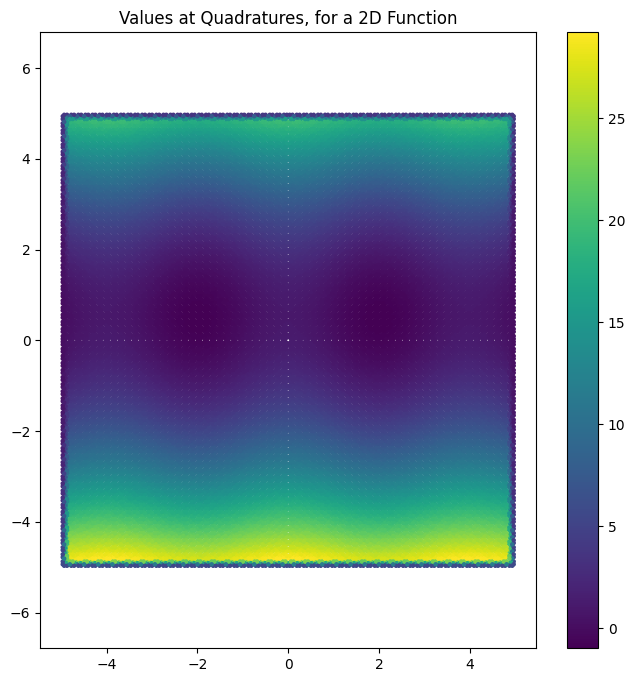

In [3]:
A,B = 1,1
omega = jnp.pi / 2
def v(x,y):
    return A * jnp.cos(omega*x) + B * (y-0.5)**2 

def lagrangian_density(u,grad_u,x):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y = x[0], x[1]
    f = v(x,y)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density,u_global)

# Plot the 2D Potential, to Visualize
femsystem.plot_values_2d(v)

## Step 3: Run Optimization Loop

In [4]:
# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.31837284564971924 Objective Value:9.581140518188477  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.22245140373706818 Objective Value:4.2473978996276855  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.1270957738161087 Objective Value:2.769235134124756  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.10854935646057129 Objective Value:2.182039976119995  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.05974084511399269 Objective Value:1.7891125679016113  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.047736652195453644 Objective Value:1.448587417602539  Stepsize:1.0  Number Linesea

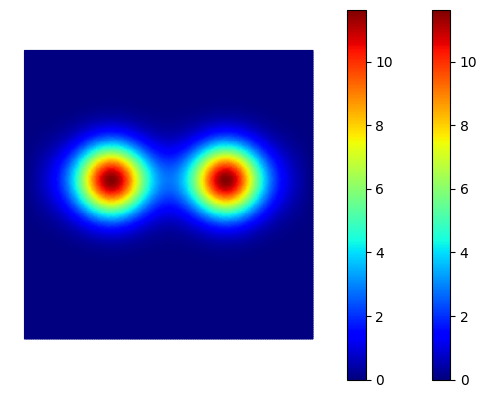

In [5]:
# Plot the Solution
femsystem.plot_at_interior_2d(result)

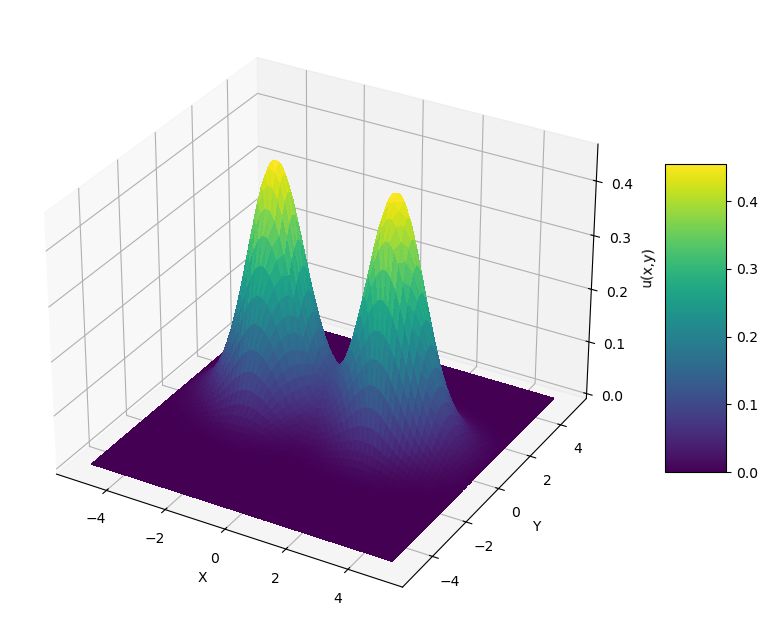

1.0


In [53]:
# Plot in 3D: 
norm = (femsystem.integrate(lambda u,grad_u,x:u**2,femsystem._get_u_from_interior(result)))
result = result/jnp.sqrt(norm)
femsystem.plot_at_interior_2d_in3d(result)
print(femsystem.integrate(lambda u,grad_u,x:u**2,femsystem._get_u_from_interior(result)))

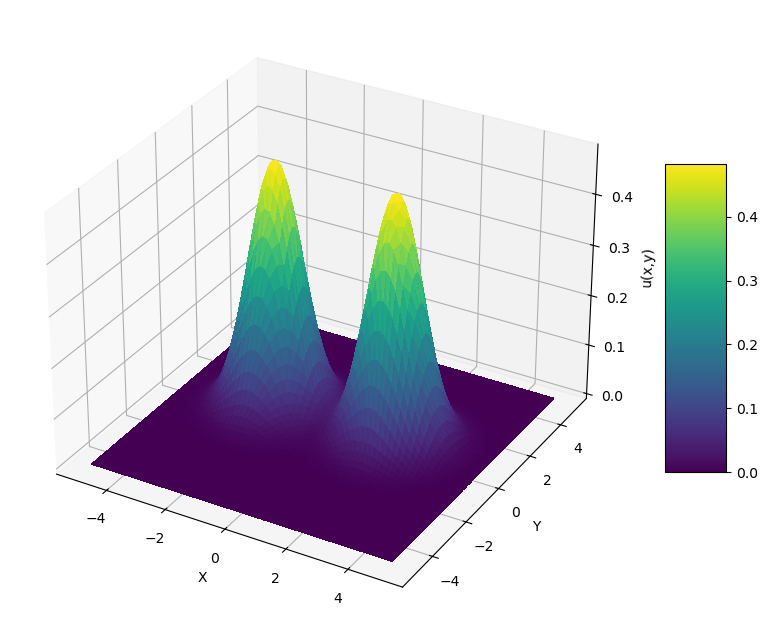

4.10605


In [56]:
import numpy as np
import scipy.special as sp

def analytical_solution(x, y, A=A, B=B, omega=omega):
    # 1. Convert Coordinate Arrays
    x_np = np.array(x)
    y_np = np.array(y)
    
    # 2. Convert Parameters to Scalar Floats
    # If A, B, or omega are JAX arrays, q becomes a JAX array, crashing Scipy
    A_val = float(A)
    B_val = float(B)
    omega_val = float(omega)
    
    # Y-Dimension
    omega_y = np.sqrt(2 * B_val)
    norm_y = (omega_y / np.pi)**0.25
    psi_y = norm_y * np.exp(-omega_y * (y_np-0.5)**2 / 2)
    
    # X-Dimension
    q = 4 * A_val / (omega_val**2)
    
    # Scipy Mathieu
    a_val = sp.mathieu_a(0, q)
    z_val = (omega_val / 2) * x_np
    ce0, _ = sp.mathieu_cem(0, q, z_val * 180 / np.pi)
    
    psi_x = ce0
    
    return psi_x * psi_y

def analytical_solution_normalized(x, y, A=A, B=B, omega=omega):
    # Ensure inputs are numpy for stability
    x = np.array(x)
    y = np.array(y)
    
    A_val = float(A)
    B_val = float(B)
    omega_val = float(omega)
    
    # --- Y-Dimension (Harmonic Oscillator) ---
    omega_y = np.sqrt(2 * B_val)
    # Analytic Normalization: (omega/pi)^(1/4)
    norm_y = (omega_y / np.pi)**0.25
    psi_y = norm_y * np.exp(-omega_y * (y - 0.5)**2 / 2)
    
    # --- X-Dimension (Harmonic Approx for Deep Wells) ---
    # Minima at x = +/- 2 (for omega = pi/2)
    # Effective frequency omega_x = sqrt(V'') = sqrt(A)*omega
    alpha = np.sqrt(A_val) * omega_val
    
    # Superposition of two Gaussians
    g1 = np.exp(-alpha * (x - 2)**2 / 2)
    g2 = np.exp(-alpha * (x + 2)**2 / 2)
    
    # Analytic Normalization for sum of two non-overlapping Gaussians
    # Norm of one gaussian e^(-alpha*x^2/2) is (alpha/pi)^(1/4)
    # We have two, so divide by sqrt(2)
    norm_x = (alpha / np.pi)**0.25 / np.sqrt(2)
    
    psi_x = norm_x * (g1 + g2)
    
    return psi_x * psi_y



femsystem.plot_func_2d_in3d(analytical_solution_normalized)

print(femsystem.integrate_function(lambda x: analytical_solution_normalized(x[0],x[1])))